In [1]:
#import section
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.datasets import mnist
from numpy.random import randn
from numpy.random.mtrand import randint
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Conv2DTranspose
from keras.layers import Conv2D
from keras.layers import Reshape
from keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from keras import initializers
from keras.utils.vis_utils import plot_model
from sklearn.metrics import precision_recall_fscore_support

In [2]:
#loading the data
X_train = np.load("Processed_Data/rooms_train.npy")
X_test = np.load("Processed_Data/rooms_test.npy")

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 16384)             344064    
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_14 (Conv2DT (None, 16, 16, 128)       524416    
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 16, 1)         2049      
Total params: 870,529
Trainable params: 870,529
Non-trainable params: 0
_______________________________________________

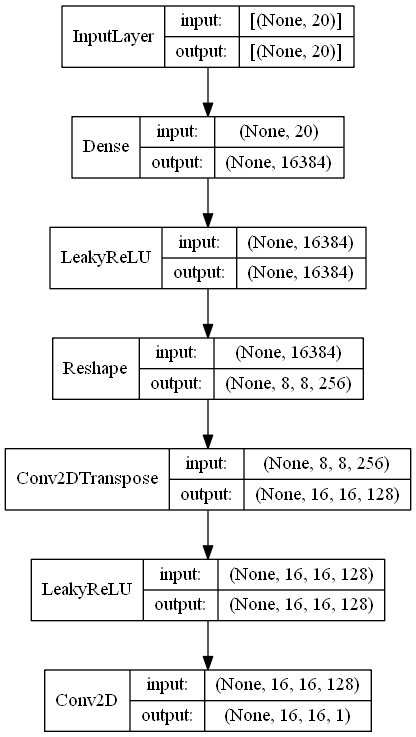

In [25]:
#generator function
def get_generator(random_dim):
  generator = Sequential()

  #foundation for 4x4 image
  n_nodes = 256 * 8 * 8
  generator.add(Dense(n_nodes, input_dim=random_dim))
  generator.add(LeakyReLU(0.2))
  generator.add(Reshape((8, 8, 256)))
    
  #upsample to 16x16
  generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  generator.add(LeakyReLU(0.2))

  generator.add(Conv2D(1, (4,4), activation='tanh', padding='same'))
  return generator

generator = get_generator(20)
generator.summary()
plot_model(generator, show_shapes=True, show_layer_names=False)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 16, 16, 128)       2176      
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 8, 128)         262272    
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)               

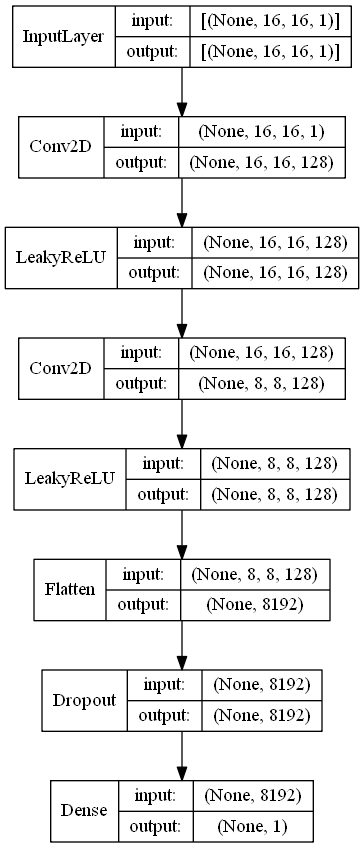

In [26]:
#discriminator function
def get_discriminator(input_shape=(16,16,1)):
  discriminator = Sequential()

  #normal
  discriminator.add(Conv2D(128, (4,4), padding='same', input_shape=input_shape))
  discriminator.add(LeakyReLU(0.2))

  #downsample
  discriminator.add(Conv2D(128, (4,4), strides=(2,2), padding='same'))
  discriminator.add(LeakyReLU(0.2))

  discriminator.add(Flatten())
  discriminator.add(Dropout(0.4))
  discriminator.add(Dense(1, activation='sigmoid'))

  optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
  discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return discriminator

discriminator = get_discriminator()
discriminator.summary()
plot_model(discriminator, show_shapes=True, show_layer_names=False)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_14 (Sequential)   (None, 16, 16, 1)         870529    
_________________________________________________________________
sequential_15 (Sequential)   (None, 1)                 272641    
Total params: 1,143,170
Trainable params: 870,529
Non-trainable params: 272,641
_________________________________________________________________


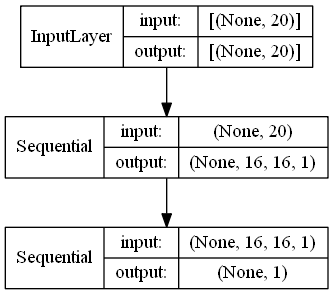

In [27]:
#gan function
def get_gan_network(generator, discriminator):
  discriminator.trainable = False
  gan = Sequential()
  gan.add(generator)
  gan.add(discriminator)
  optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
  gan.compile(loss='binary_crossentropy', optimizer=optimizer)
  return gan

gan = get_gan_network(generator, discriminator)
gan.summary()
plot_model(gan, show_shapes=True, show_layer_names=False)

In [28]:
#ploting dungeons function
def plot_generated_dungeons(epoch, generator, random_dim, examples=25, dim=(5,5), figsize=(10,10)):
  noise = np.random.normal(0, 1, size=[examples, random_dim])
  generated_dungeons = generator.predict(noise)
  generated_dungeons = generated_dungeons.reshape(examples, 16, 16)

  plt.figure(figsize=figsize)
  for i in range(generated_dungeons.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(generated_dungeons[i], interpolation='nearest')
    plt.axis('off')
  plt.tight_layout()
  plt.savefig('Room_Images/gan_generated_rooms_epoch_%d.png' % epoch)

In [29]:
def generate_random_noise(random_dim, n_samples):
  noise = randn(random_dim * n_samples)
  noise = noise.reshape(n_samples, random_dim)
  return noise

In [30]:
def generate_real_samples(n_samples):
  indices = randint(0, X_train.shape[0], n_samples)
  X_real = X_train[indices]
  X_real = X_real.reshape(X_real.shape[0], 16, 16, 1)
  y_real = np.ones((n_samples, 1)) * 0.9
  return X_real, y_real

In [31]:
def generate_fake_samples(generator, random_dim, n_samples):
  noise = generate_random_noise(random_dim, n_samples)
  X_fake = generator.predict(noise)
  y_fake = np.zeros((n_samples, 1))
  return X_fake, y_fake

In [32]:
def evaluation(generator, discriminator, random_dim):
  X_test_real = X_test.reshape(X_test.shape[0], 16, 16, 1)
  y_test_real = np.ones((X_test.shape[0], 1))

  X_test_fake, y_test_fake = generate_fake_samples(generator, random_dim, X_test.shape[0])

  X = np.concatenate([X_test_real, X_test_fake])
  y = np.concatenate([y_test_real, y_test_fake])

  y_pred = discriminator.predict(X)
  for i in range(len(y_pred)):
    if y_pred[i] >= 0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
  precision, recall, f1, _ = precision_recall_fscore_support(y, y_pred, average='binary')

  #computing norm of standard deviation matrix to ckeck the diversity of generated data
  diversity_generated = np.linalg.norm(X_test_fake.std(0))
    
  return precision, recall, f1, diversity_generated

In [33]:
#training part
def train(random_dim, epochs=100, batch_size=32):

  batch_count = int(X_train.shape[0] / batch_size)
  half_batch = int(batch_size / 2)

  generator = get_generator(random_dim)
  discriminator = get_discriminator()
  gan = get_gan_network(generator, discriminator)
  
  precision = []
  recall = []
  f1 = []
  diversity = []
    
  for e in range(1, epochs+1):
    print('-'*15, 'Epoch %d' % e, '-'*15)
    for i in tqdm(range(batch_count)):
      
      discriminator.trainable = True
      X_real, y_real = generate_real_samples(half_batch)
      discriminator.train_on_batch(X_real, y_real)

      X_fake, y_fake = generate_fake_samples(generator, random_dim, half_batch)
      discriminator.train_on_batch(X_fake, y_fake)

      X_gan = generate_random_noise(random_dim, batch_size)
      y_gan = np.ones((batch_size, 1))
      
      discriminator.trainable = False
      gan.train_on_batch(X_gan, y_gan)

    p, r, f, d = evaluation(generator, discriminator, random_dim)
    precision.append(p)
    recall.append(r)
    f1.append(f)
    diversity.append(d)

    if e == 1 or e % 20 == 0:
      plot_generated_dungeons(e, generator, random_dim)
      print("epoch {}: precision = {}, recall = {}, f1 = {}, diversity = {}".format(e, p, r, f, d))
    
    if e == epochs:
      generator.save("Room_Models/generator_model_epoch_{}.h5".format(e))
      discriminator.save("Room_Models/discriminator_model_epoch_{}.h5".format(e))
      gan.save("Room_Models/gan_model_epoch_{}.h5".format(e))
    
      plt.figure()
      plt.plot(range(1, epochs + 1), precision, label='Precision')
      plt.plot(range(1, epochs + 1), recall, label='Recall')
      plt.plot(range(1, epochs + 1), f1, label='F1')
      plt.legend()
      plt.xlabel("Epoch")
      plt.show()
        
      plt.figure()
      plt.plot(range(1, epochs + 1), diversity)
      plt.xlabel("Epoch")
      plt.ylabel("Diversity of Generated Data")
      plt.show()
      

--------------- Epoch 1 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.79it/s]


epoch 1: precision = 0.5, recall = 1.0, f1 = 0.6666666666666666, diversity = 1.0315383672714233
--------------- Epoch 2 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.83it/s]


--------------- Epoch 3 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.70it/s]


--------------- Epoch 4 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.64it/s]


--------------- Epoch 5 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.32it/s]


--------------- Epoch 6 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.67it/s]


--------------- Epoch 7 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.70it/s]


--------------- Epoch 8 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.84it/s]


--------------- Epoch 9 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.59it/s]


--------------- Epoch 10 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.51it/s]


--------------- Epoch 11 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.17it/s]


--------------- Epoch 12 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.68it/s]


--------------- Epoch 13 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.72it/s]


--------------- Epoch 14 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.64it/s]


--------------- Epoch 15 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.81it/s]


--------------- Epoch 16 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.58it/s]


--------------- Epoch 17 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.18it/s]


--------------- Epoch 18 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.77it/s]


--------------- Epoch 19 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.65it/s]


--------------- Epoch 20 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.53it/s]


epoch 20: precision = 0.8693877551020408, recall = 0.34521880064829824, f1 = 0.4941995359628771, diversity = 7.0426411628723145
--------------- Epoch 21 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  7.93it/s]


--------------- Epoch 22 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.36it/s]


--------------- Epoch 23 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.30it/s]


--------------- Epoch 24 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.63it/s]


--------------- Epoch 25 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.58it/s]


--------------- Epoch 26 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.65it/s]


--------------- Epoch 27 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.56it/s]


--------------- Epoch 28 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.31it/s]


--------------- Epoch 29 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.17it/s]


--------------- Epoch 30 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.79it/s]


--------------- Epoch 31 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.82it/s]


--------------- Epoch 32 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.70it/s]


--------------- Epoch 33 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.74it/s]


--------------- Epoch 34 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.85it/s]


--------------- Epoch 35 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.32it/s]


--------------- Epoch 36 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.65it/s]


--------------- Epoch 37 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  8.38it/s]


--------------- Epoch 38 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.44it/s]


--------------- Epoch 39 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.66it/s]


--------------- Epoch 40 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.58it/s]


epoch 40: precision = 0.946360153256705, recall = 0.40032414910858993, f1 = 0.5626423690205011, diversity = 6.786447525024414
--------------- Epoch 41 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.89it/s]


--------------- Epoch 42 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.88it/s]


--------------- Epoch 43 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.76it/s]


--------------- Epoch 44 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  8.27it/s]


--------------- Epoch 45 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.64it/s]


--------------- Epoch 46 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.03it/s]


--------------- Epoch 47 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.79it/s]


--------------- Epoch 48 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.74it/s]


--------------- Epoch 49 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.68it/s]


--------------- Epoch 50 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.63it/s]


--------------- Epoch 51 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.88it/s]


--------------- Epoch 52 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.91it/s]


--------------- Epoch 53 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.76it/s]


--------------- Epoch 54 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.20it/s]


--------------- Epoch 55 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.57it/s]


--------------- Epoch 56 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.50it/s]


--------------- Epoch 57 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  8.89it/s]


--------------- Epoch 58 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.59it/s]


--------------- Epoch 59 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.53it/s]


--------------- Epoch 60 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.49it/s]


epoch 60: precision = 0.9887323943661972, recall = 0.5688816855753647, f1 = 0.7222222222222222, diversity = 5.650096893310547
--------------- Epoch 61 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.46it/s]


--------------- Epoch 62 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  8.51it/s]


--------------- Epoch 63 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.67it/s]


--------------- Epoch 64 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.49it/s]


--------------- Epoch 65 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.72it/s]


--------------- Epoch 66 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.29it/s]


--------------- Epoch 67 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.88it/s]


--------------- Epoch 68 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.70it/s]


--------------- Epoch 69 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.41it/s]


--------------- Epoch 70 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.61it/s]


--------------- Epoch 71 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.53it/s]


--------------- Epoch 72 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.64it/s]


--------------- Epoch 73 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.61it/s]


--------------- Epoch 74 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.09it/s]


--------------- Epoch 75 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.71it/s]


--------------- Epoch 76 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.88it/s]


--------------- Epoch 77 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.77it/s]


--------------- Epoch 78 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.56it/s]


--------------- Epoch 79 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.68it/s]


--------------- Epoch 80 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.45it/s]


epoch 80: precision = 0.9947916666666666, recall = 0.6191247974068071, f1 = 0.7632367632367631, diversity = 5.920039653778076
--------------- Epoch 81 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  8.39it/s]


--------------- Epoch 82 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.59it/s]


--------------- Epoch 83 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.62it/s]


--------------- Epoch 84 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  8.88it/s]


--------------- Epoch 85 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.61it/s]


--------------- Epoch 86 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.60it/s]


--------------- Epoch 87 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.70it/s]


--------------- Epoch 88 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.07it/s]


--------------- Epoch 89 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.64it/s]


--------------- Epoch 90 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  8.34it/s]


--------------- Epoch 91 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.52it/s]


--------------- Epoch 92 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.33it/s]


--------------- Epoch 93 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.81it/s]


--------------- Epoch 94 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.66it/s]


--------------- Epoch 95 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.77it/s]


--------------- Epoch 96 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.52it/s]


--------------- Epoch 97 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.11it/s]


--------------- Epoch 98 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.76it/s]


--------------- Epoch 99 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.79it/s]


--------------- Epoch 100 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.64it/s]


epoch 100: precision = 1.0, recall = 0.6693679092382496, f1 = 0.8019417475728156, diversity = 5.43256950378418
--------------- Epoch 101 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.80it/s]


--------------- Epoch 102 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.72it/s]


--------------- Epoch 103 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.12it/s]


--------------- Epoch 104 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.84it/s]


--------------- Epoch 105 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.77it/s]


--------------- Epoch 106 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.70it/s]


--------------- Epoch 107 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.72it/s]


--------------- Epoch 108 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.77it/s]


--------------- Epoch 109 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.79it/s]


--------------- Epoch 110 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.75it/s]


--------------- Epoch 111 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.76it/s]


--------------- Epoch 112 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  8.98it/s]


--------------- Epoch 113 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.39it/s]


--------------- Epoch 114 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.73it/s]


--------------- Epoch 115 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.76it/s]


--------------- Epoch 116 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.87it/s]


--------------- Epoch 117 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.71it/s]


--------------- Epoch 118 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.71it/s]


--------------- Epoch 119 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.80it/s]


--------------- Epoch 120 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.76it/s]


epoch 120: precision = 1.0, recall = 0.7034035656401945, f1 = 0.8258801141769743, diversity = 5.055718898773193
--------------- Epoch 121 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.82it/s]


--------------- Epoch 122 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.74it/s]


--------------- Epoch 123 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.70it/s]


--------------- Epoch 124 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.72it/s]


--------------- Epoch 125 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.74it/s]


--------------- Epoch 126 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.75it/s]


--------------- Epoch 127 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.72it/s]


--------------- Epoch 128 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.07it/s]


--------------- Epoch 129 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.77it/s]


--------------- Epoch 130 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.67it/s]


--------------- Epoch 131 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.57it/s]


--------------- Epoch 132 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.55it/s]


--------------- Epoch 133 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.76it/s]


--------------- Epoch 134 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.66it/s]


--------------- Epoch 135 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.69it/s]


--------------- Epoch 136 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.78it/s]


--------------- Epoch 137 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  8.96it/s]


--------------- Epoch 138 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.80it/s]


--------------- Epoch 139 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.89it/s]


--------------- Epoch 140 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.78it/s]


epoch 140: precision = 1.0, recall = 0.6758508914100486, f1 = 0.8065764023210832, diversity = 4.713409900665283
--------------- Epoch 141 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.12it/s]


--------------- Epoch 142 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.64it/s]


--------------- Epoch 143 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.85it/s]


--------------- Epoch 144 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.71it/s]


--------------- Epoch 145 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  8.98it/s]


--------------- Epoch 146 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.78it/s]


--------------- Epoch 147 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.77it/s]


--------------- Epoch 148 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.63it/s]


--------------- Epoch 149 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.49it/s]


--------------- Epoch 150 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.72it/s]


--------------- Epoch 151 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.69it/s]


--------------- Epoch 152 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.79it/s]


--------------- Epoch 153 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.84it/s]


--------------- Epoch 154 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.70it/s]


--------------- Epoch 155 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  8.96it/s]


--------------- Epoch 156 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.71it/s]


--------------- Epoch 157 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.63it/s]


--------------- Epoch 158 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.71it/s]


--------------- Epoch 159 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.83it/s]


--------------- Epoch 160 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.73it/s]


epoch 160: precision = 0.9978354978354979, recall = 0.747163695299838, f1 = 0.8544949026876738, diversity = 4.437752723693848
--------------- Epoch 161 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.86it/s]


--------------- Epoch 162 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.83it/s]


--------------- Epoch 163 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  8.98it/s]


--------------- Epoch 164 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.92it/s]


--------------- Epoch 165 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.56it/s]


--------------- Epoch 166 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.80it/s]


--------------- Epoch 167 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.78it/s]


--------------- Epoch 168 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.79it/s]


--------------- Epoch 169 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.09it/s]


--------------- Epoch 170 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.64it/s]


--------------- Epoch 171 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.62it/s]


--------------- Epoch 172 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.80it/s]


--------------- Epoch 173 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.68it/s]


--------------- Epoch 174 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  8.87it/s]


--------------- Epoch 175 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.72it/s]


--------------- Epoch 176 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.70it/s]


--------------- Epoch 177 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.74it/s]


--------------- Epoch 178 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.68it/s]


--------------- Epoch 179 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.82it/s]


--------------- Epoch 180 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.71it/s]


epoch 180: precision = 0.9955156950672646, recall = 0.7196110210696921, f1 = 0.8353715898400754, diversity = 4.5587992668151855
--------------- Epoch 181 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.75it/s]


--------------- Epoch 182 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.08it/s]


--------------- Epoch 183 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.81it/s]


--------------- Epoch 184 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.59it/s]


--------------- Epoch 185 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.79it/s]


--------------- Epoch 186 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.76it/s]


--------------- Epoch 187 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.73it/s]


--------------- Epoch 188 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.76it/s]


--------------- Epoch 189 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.51it/s]


--------------- Epoch 190 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.80it/s]


--------------- Epoch 191 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.82it/s]


--------------- Epoch 192 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.55it/s]


--------------- Epoch 193 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.63it/s]


--------------- Epoch 194 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.85it/s]


--------------- Epoch 195 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.80it/s]


--------------- Epoch 196 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.72it/s]


--------------- Epoch 197 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.66it/s]


--------------- Epoch 198 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.11it/s]


--------------- Epoch 199 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.70it/s]


--------------- Epoch 200 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00,  9.71it/s]


epoch 200: precision = 0.9678800856531049, recall = 0.7325769854132901, f1 = 0.8339483394833948, diversity = 4.5762553215026855


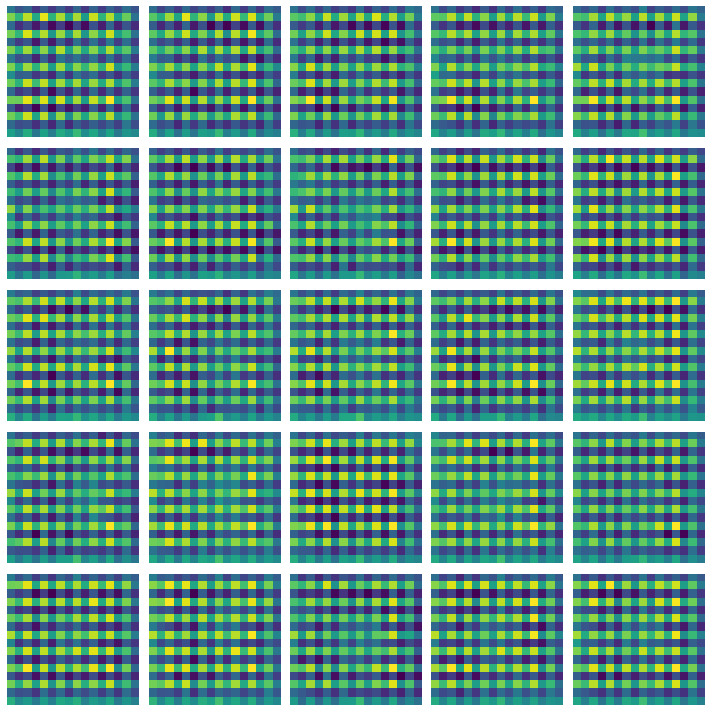

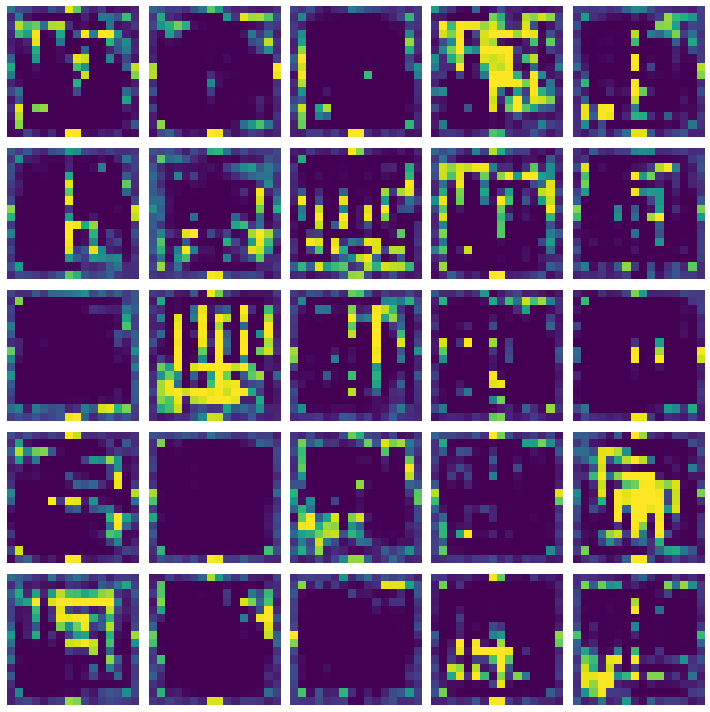

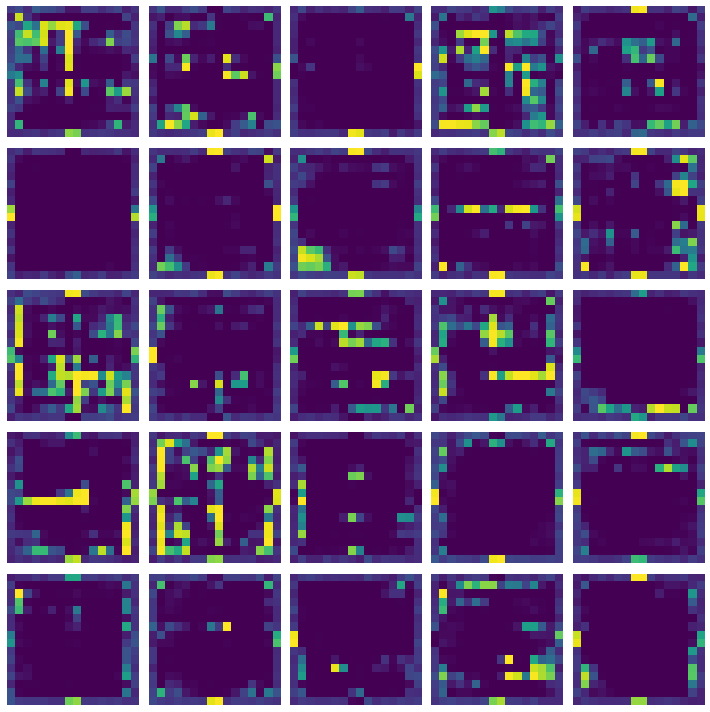

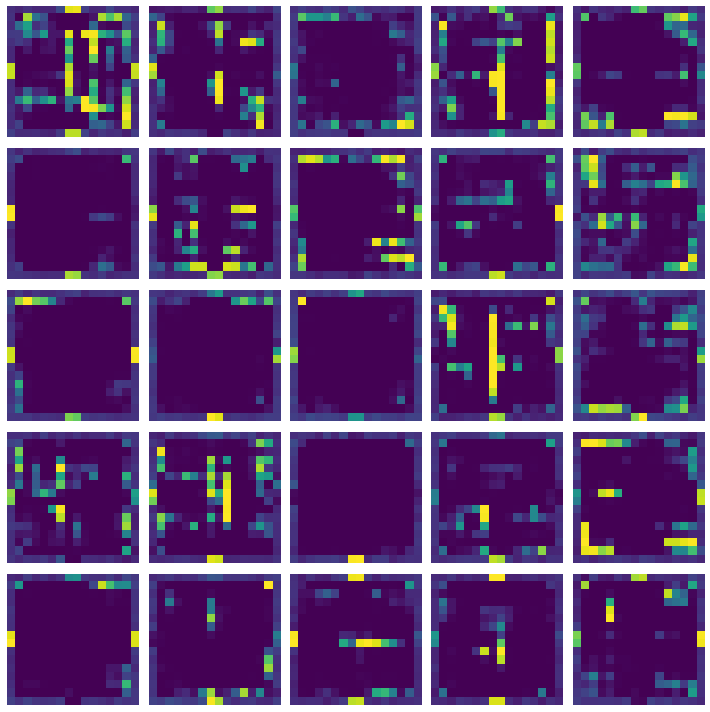

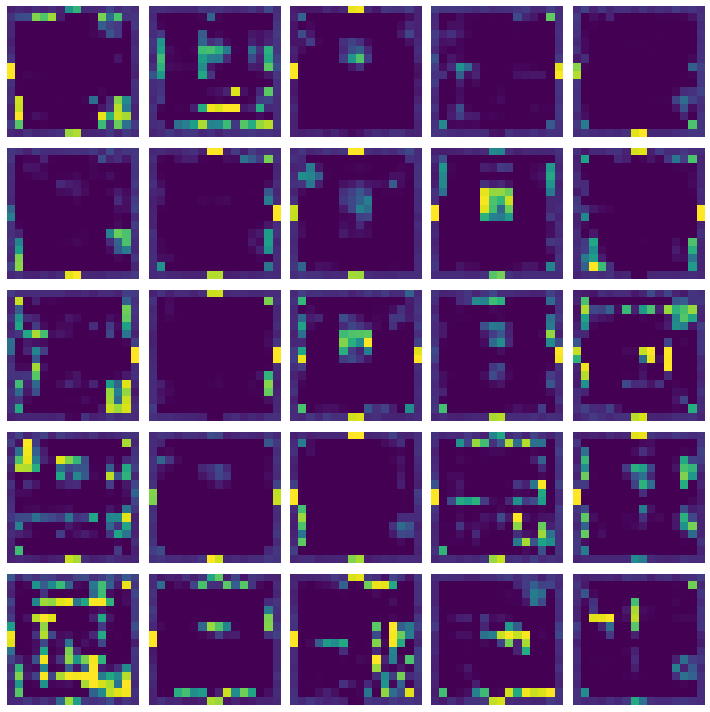

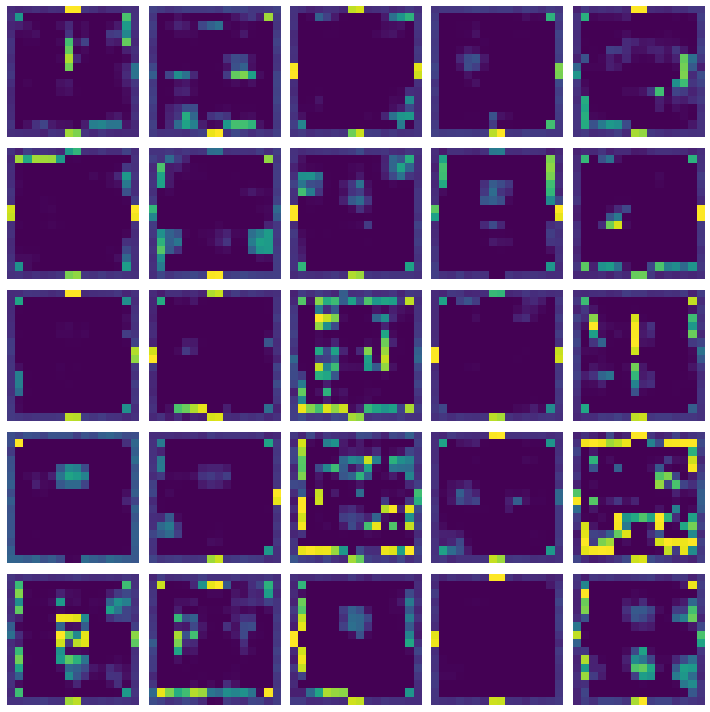

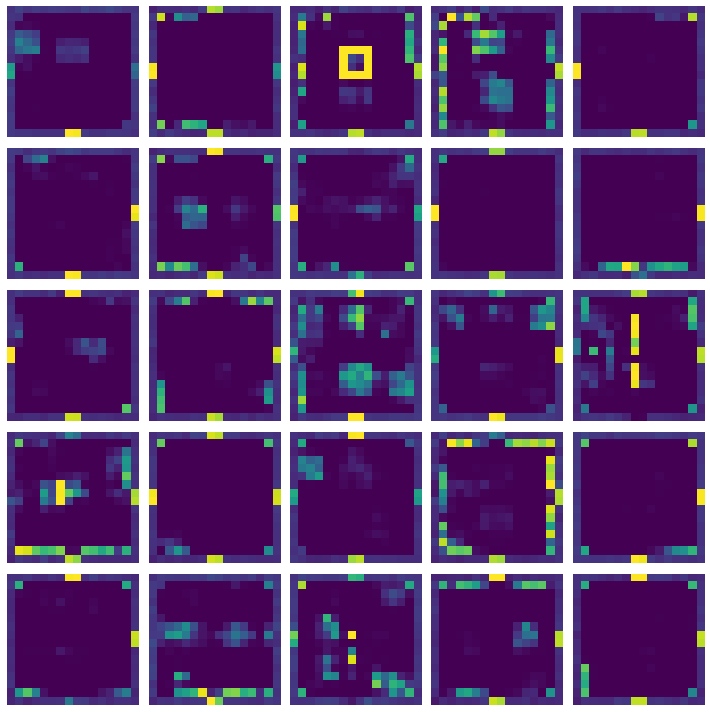

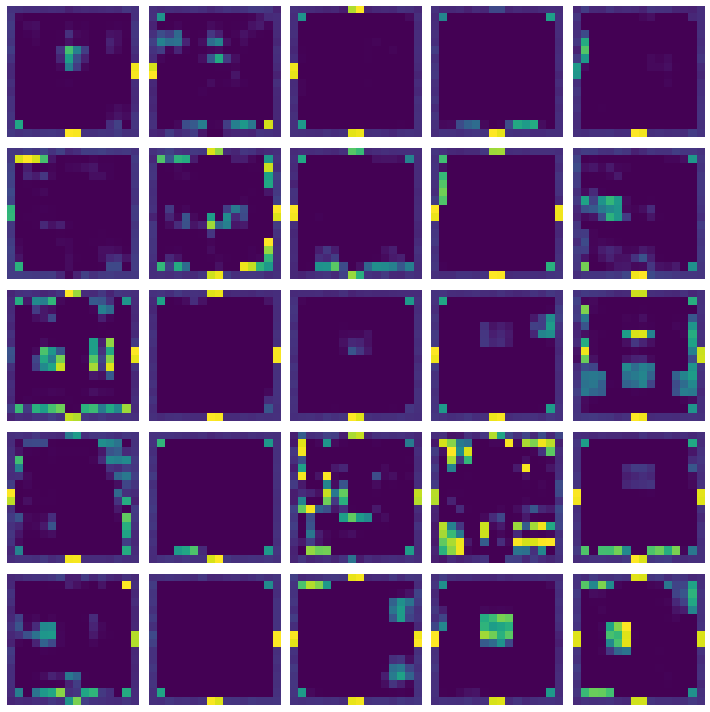

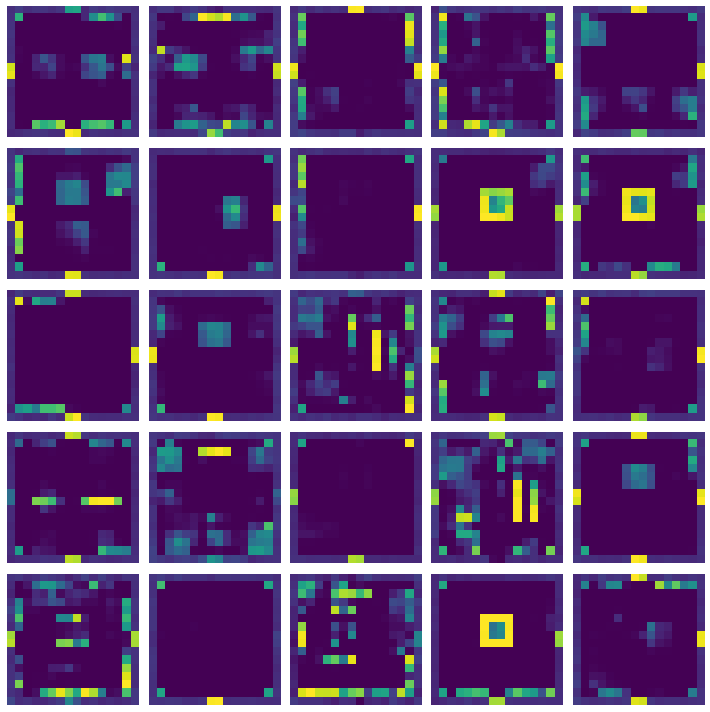

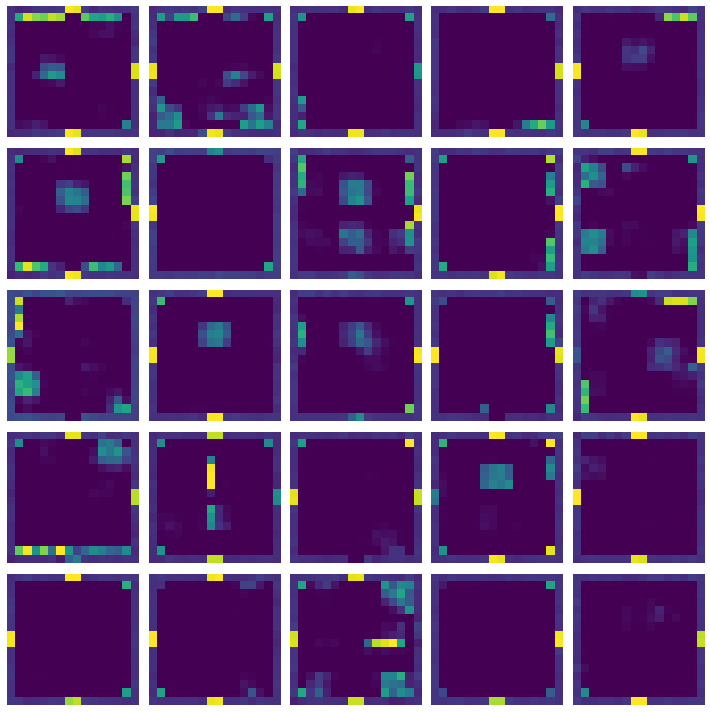

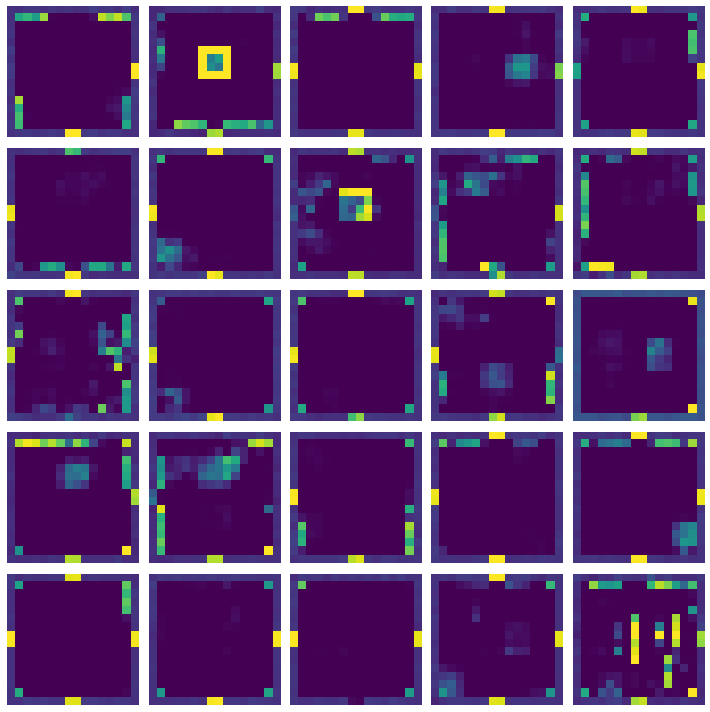

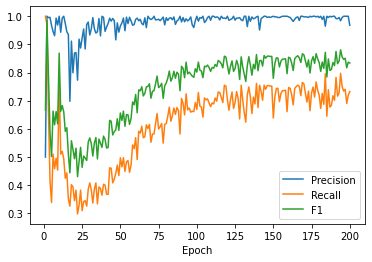

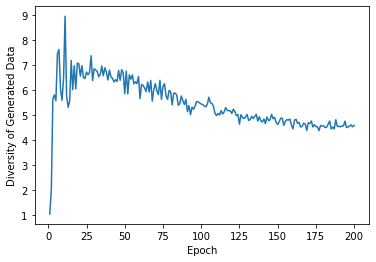

In [34]:
#main section
if __name__ == '__main__':
  os.environ["KERAS_BACKEND"] = "tensorflow"
  random_dim = 25
  train(random_dim, epochs=200, batch_size=64)